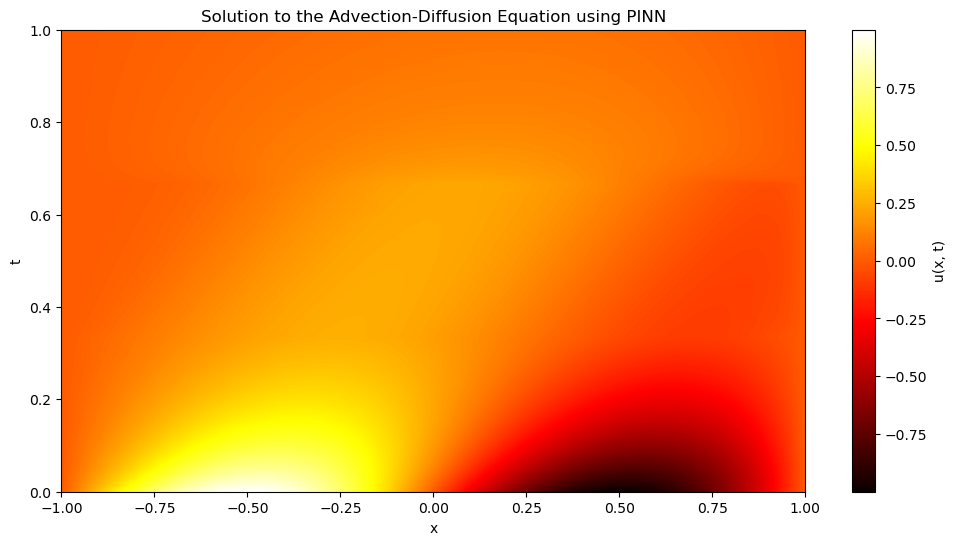

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# Ensure that animations display properly in the notebook
%matplotlib inline

# Define spatial parameters
x_min = -1.0
x_max = 1.0
Nx = 1024          # Spatial resolution
x = np.linspace(x_min, x_max, Nx)
dx = x[1] - x[0]

# Advection speed
c = 1.0

# Adjust dt based on CFL condition for advection
dt_max = dx / c
dt = dt_max * 0.5  # Use 50% of the maximum allowable dt for stability

# Define time intervals
t0 = 0.0
t1 = 1.0 / 3.0
t2 = 2.0 / 3.0
t3 = 1.0

# Calculate the number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = int((t3 - t2) / dt) + 1

# Recalculate dt to fit the time intervals exactly
dt1 = (t1 - t0) / (Nt1 - 1)
dt2 = (t2 - t1) / (Nt2 - 1)
dt3 = (t3 - t2) / (Nt3 - 1)

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)

# Combine time vectors for plotting, removing duplicate points at overlaps
t = np.concatenate((t_interval1[:-1], t_interval2[:-1], t_interval3))

# Initialize solution array with adjusted size
Nt_combined = Nt1 + Nt2 + Nt3 - 2  # Subtract overlaps
u_total = np.zeros((Nt_combined, Nx))

# New initial condition: u(t=0, x) = -sin(π x)
u0 = -np.sin(np.pi * x)
u_total[0, :] = u0

# Boundary conditions (already satisfied by the initial condition)
u_total[:, 0] = 0.0     # u(-1, t) = 0
u_total[:, -1] = 0.0    # u(1, t) = 0

# Function to solve the PDE over a given interval
def solve_interval(u_initial, t_start, t_end, Nt_interval, lambda_n, dt_interval):
    dt = dt_interval
    CFL_advection = c * dt / dx
    if CFL_advection > 1.0:
        print(f"Warning: CFL condition for advection not satisfied in interval [{t_start}, {t_end}]. Adjust dt or dx for stability.")

    u = np.zeros((Nt_interval, Nx))
    u[0, :] = u_initial
    u[:, 0] = 0.0     # Boundary condition at x=0
    u[:, -1] = 0.0    # Boundary condition at x=1

    # Coefficient for diffusion term
    a = lambda_n * dt / dx**2

    # Time-stepping
    for n in range(0, Nt_interval - 1):
        # Coefficients for the tridiagonal matrix
        lower = -a * np.ones(Nx - 3)
        main = (1 + 2 * a) * np.ones(Nx - 2)
        upper = -a * np.ones(Nx - 3)

        # Build RHS of the system
        RHS = u[n, 1:-1] - dt * (u[n, 1:-1] - u[n, 0:-2]) / dx

        # Forward sweep (Thomas algorithm)
        for j in range(1, Nx - 2):
            w = lower[j - 1] / main[j - 1]
            main[j] = main[j] - w * upper[j - 1]
            RHS[j] = RHS[j] - w * RHS[j - 1]

        # Back substitution
        u_new = np.zeros(Nx - 2)
        u_new[-1] = RHS[-1] / main[-1]
        for j in range(Nx - 4, -1, -1):
            u_new[j] = (RHS[j] - upper[j] * u_new[j + 1]) / main[j]

        # Update solution
        u[n + 1, 1:-1] = u_new

    return u

# Solve over the first interval [t0, t1]
lambda1 = 0.5
u_interval1 = solve_interval(u_total[0, :], t0, t1, Nt1, lambda1, dt1)
u_total[0:Nt1, :] = u_interval1

# Solve over the second interval [t1, t2]
lambda2 = 0.05
u_initial2 = u_interval1[-1, :] #Initial condition for second interval is the final time configuration of the first interval solution
u_interval2 = solve_interval(u_initial2, t1, t2, Nt2, lambda2, dt2)
u_total[Nt1 - 1:Nt1 + Nt2 - 1, :] = u_interval2

# Solve over the third interval [t2, t3]
lambda3 = 1.0
u_initial3 = u_interval2[-1, :]
u_interval3 = solve_interval(u_initial3, t2, t3, Nt3, lambda3, dt3)
u_total[Nt1 + Nt2 - 2:, :] = u_interval3
'''
# Prepare the data for animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], lw=2)
ax.set_xlim(x_min, x_max)
ax.set_ylim(-1.1, 1.1)
ax.set_xlabel('Spatial Coordinate x')
ax.set_ylabel('u(x, t)')
ax.set_title('Evolution of u(x, t) Over Time')

# Initialize function for animation
def init():
    line.set_data([], [])
    return line,

# Animation function
def animate(i):
    y = u_total[i, :]
    line.set_data(x, y)
    ax.set_title(f'Evolution of u(x, t) at t = {t[i]:.3f}')
    return line,

# Create the animation
frame_interval = 1  # Adjust this to control the speed of the animation
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=Nt_combined, interval=frame_interval, blit=True)

# Display the animation in the notebook
HTML(anim.to_jshtml())
'''
plt.figure(figsize=(12, 6))
plt.imshow(u_total, extent=[-1, 1, 0, 1], origin='lower', aspect='auto', cmap='hot')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solution to the Advection-Diffusion Equation using PINN')
plt.show()

In [3]:
# Calculate the number of time steps for each interval
Nt1 = int((t1 - t0) / dt) + 1
Nt2 = int((t2 - t1) / dt) + 1
Nt3 = int((t3 - t2) / dt) + 1
print(Nt1,Nt2,Nt3)
# Recalculate dt to fit the time intervals exactly
dt1 = (t1 - t0) / (Nt1 - 1)
dt2 = (t2 - t1) / (Nt2 - 1)
dt3 = (t3 - t2) / (Nt3 - 1)
print(dt1,dt2,dt3)

# Time vectors for each interval
t_interval1 = np.linspace(t0, t1, Nt1)
t_interval2 = np.linspace(t1, t2, Nt2)
t_interval3 = np.linspace(t2, t3, Nt3)
print(t_interval1.shape,t_interval2.shape,t_interval3.shape)

342 342 342
0.0009775171065493646 0.0009775171065493646 0.0009775171065493648
(342,) (342,) (342,)


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Parameters
learning_rate = 0.00001
eta = learning_rate
num_epochs = 25000

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the domain for x and t
x_values = np.linspace(-1, 1, Nx)
t_values = np.linspace(0, 1, Nt_combined)
X, T = np.meshgrid(x_values, t_values)
x_t_grid = torch.tensor(np.c_[X.ravel(), T.ravel()], dtype=torch.float32).to(device)
# Get the total number of x values in each t slice (201 in your case)
num_x_values = x_values.shape[0] #201
N_total = Nx*Nt_combined
# Extract the first occurrence of each time value by taking a slice with step `num_x_values`
t_grid = x_t_grid[::num_x_values, 1]
t_grid = t_grid.unsqueeze(1)


#Defining Spatial Batches
Batches = []
for i in range(Nx):
    # Find indices in x_t_grid corresponding to the i-th x point
    indices = (x_t_grid[:, 0] == x_values[i])
    # Select all (x, t) points for the current x value
    Batch = x_t_grid[indices]
    Batches.append(Batch)


import torch
from torch.utils.data import Dataset

class GridDataset(Dataset):
    def __init__(self, x_t_grid, x_values, u_total):
        
        self.x_t_grid = x_t_grid
        self.x_values = x_values
        self.u_total = u_total

    def __len__(self):
        
        return len(self.x_values)

    def __getitem__(self, idx):
    
        x_value = self.x_values[idx]
        indices = (self.x_t_grid[:, 0] == x_value)
        batch = self.x_t_grid[indices]
        u_values = self.u_total[:,idx]
        
        # Convert to torch tensors
        u_values_tensor = torch.tensor(u_values, dtype=torch.float32,device=device)
        
        return batch, u_values_tensor


# Create dataset and dataloader
grid_dataset = GridDataset(x_t_grid, x_values,u_total)
dataloader = DataLoader(grid_dataset, batch_size=128, shuffle=True)

Using device: cuda


In [5]:
Nt_combined

1024

In [6]:
# Print contents of the DataLoader
for index, items in enumerate(dataloader):
    print(items[0].shape, items[1].shape)

torch.Size([128, 1024, 2]) torch.Size([128, 1024])
torch.Size([128, 1024, 2]) torch.Size([128, 1024])
torch.Size([128, 1024, 2]) torch.Size([128, 1024])
torch.Size([128, 1024, 2]) torch.Size([128, 1024])
torch.Size([128, 1024, 2]) torch.Size([128, 1024])
torch.Size([128, 1024, 2]) torch.Size([128, 1024])
torch.Size([128, 1024, 2]) torch.Size([128, 1024])
torch.Size([128, 1024, 2]) torch.Size([128, 1024])


In [7]:
items[1].shape

torch.Size([128, 1024])

In [8]:
items[0].shape

torch.Size([128, 1024, 2])

In [9]:
# Neural network model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # Network for u(x, t)
        self.fc1_u = nn.Linear(2, 50)
        self.fc2_u = nn.Linear(50, 50)
        self.fc3_u = nn.Linear(50, 50)
        self.fc4_u = nn.Linear(50, 1)
        '''
        # Separate network for lambda(t)
        self.fc1_lambda = nn.Linear(1, 50)
        self.fc2_lambda = nn.Linear(50, 50)
        self.fc3_lambda = nn.Linear(50, 1)
        '''
    def forward(self, x):
        # Predict u(x, t) using the full (x, t) input
        u = torch.tanh(self.fc1_u(x))
        u = torch.tanh(self.fc2_u(u))
        u = torch.tanh(self.fc3_u(u))
        u = self.fc4_u(u)
        '''
        # Predict lambda(t) using only the t component
        lambda_t = torch.relu(self.fc1_lambda(t))
        lambda_t = torch.relu(self.fc2_lambda(lambda_t))
        lambda_t = self.fc3_lambda(lambda_t)
        '''
        return u


In [10]:
# Initialize the model, optimizer, and loss function
model = PINN().to(device)
# Set up learnable parameters for λ(t) at each time grid point
lambda_param = nn.Parameter(torch.ones(Nt_combined, device=device, requires_grad=True))

# Define the optimizer, including model parameters and lambda_t
optimizer = optim.Adam(list(model.parameters()) + [lambda_param], lr=eta)


In [11]:
# Function to count parameters in the optimizer
def count_optimizer_parameters(optimizer):
    total_params = 0
    for param_group in optimizer.param_groups:
        for param in param_group['params']:
            total_params += param.numel()  # numel() gives the total number of elements in the tensor
    return total_params

# Verify the total number of parameters in the optimizer
total_parameters = count_optimizer_parameters(optimizer)
print(f"Total number of parameters in the optimizer: {total_parameters}")


Total number of parameters in the optimizer: 6325


In [12]:
# Compute the physics-informed loss
def physics_informed_loss(model, x_t):
    x_t.requires_grad = True
    u = model(x_t)
    
    # Compute gradients for ∂u/∂t and ∂u/∂x
    grads = torch.autograd.grad(u, x_t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = grads[..., 1]
    u_x = grads[..., 0]
    
    # Compute the second derivative ∂²u/∂x²
    u_x_grad = torch.autograd.grad(u_x, x_t, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_xx = u_x_grad[..., 0]
    
    #u_xx = u_xx
    #u_xx_trans = u_xx.t()
    diffusion = lambda_param*u_xx
    #diffusion = diffusion.view(-1)
    advection_diffusion_loss = u_t + u_x - diffusion

    return torch.mean(advection_diffusion_loss ** 2)

In [13]:
def training_loss(model,batch):
    x_t = batch[0]
    u_pred = model(x_t)[...,0]
    u_train = batch[1]
    return torch.mean((u_pred - u_train)**2)

In [14]:
items[0].shape

torch.Size([128, 1024, 2])

In [15]:
physics_informed_loss(model,items[0])

C:\Users\yaman\anaconda3\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.0018, device='cuda:0', grad_fn=<MeanBackward0>)

In [16]:
import torch
import torch.nn.functional as F

def lambda_loss(lambda_param):
    T = t_grid[-1] - t_grid[0]
    # Define delta(t) as sqrt(T / (T - t))
    delta_t = torch.sqrt(T / ((t_grid+0.001)*(T - t_grid)))
    delta_t = delta_t[...,0]
    # Calculate Δλ as λ(t^{i+1}) - λ(t^i)
    delta_lambda = lambda_param[1:] - lambda_param[:-1]
    
    # Compute Δλ⁺ and Δλ⁻ using ReLU for positive and negative parts
    delta_lambda_plus = F.relu(delta_lambda)              # ReLU for Δλ⁺
    delta_lambda_minus = F.relu(-delta_lambda)            # ReLU for Δλ⁻

    # Calculate V_lambda according to the given summation formula
    V_lambda = torch.sum(delta_t[:-1] * (delta_lambda_plus + delta_lambda_minus))

    return V_lambda
lambda_loss(lambda_param)

tensor(0., device='cuda:0', grad_fn=<SumBackward0>)

In [17]:
def update_weights(L_pinn, L_train, L_lambda):    
    # Compute weights using torch.exp
    W1 = torch.exp(-eta * L_pinn)
    W2 = torch.exp(-eta * L_train)
    W3 = torch.exp(-eta * L_lambda)
    
    # Normalize weights to sum to 1
    S = W1 + W2 + W3
    W1 = W1 / S
    W2 = W2 / S
    W3 = W3 / S
    
    # Convert weights to scalar values for further use
    return W1, W2, W3

In [18]:
w1 = torch.tensor(1/3, dtype=torch.float32, device=device)
w2 = torch.tensor(1/3, dtype=torch.float32, device=device)
w3 = torch.tensor(1/3, dtype=torch.float32, device=device)
#epochs = 10000
for epoch in range(num_epochs):
    loss = 0
    loss_pinn = 0
    loss_train = 0
    loss_lambda= 0
    for index, batch in enumerate(dataloader):
        
        x_t_batch = batch[0]
        u_batch = batch[1]
        
        L_pinn = physics_informed_loss(model,x_t_batch)
        L_train = training_loss(model,batch)
        L_lambda = lambda_loss(lambda_param)
        
        #L_total = L_pinn + L_train + L_lambda
        
        optimizer.zero_grad()
    
        # Step 2: Compute the total loss
        L_total = w1*L_pinn + w2*L_train + w3*L_lambda
        loss += L_total
        loss_pinn += L_pinn
        loss_train += L_train
        loss_lambda += L_lambda
        # Step 3: Backpropagate to compute gradients
        L_total.backward()
        
        # Step 4: Perform the gradient descent step
        optimizer.step()
        w1, w2, w3 = update_weights(L_pinn.detach(), L_train.detach(), L_lambda.detach())
    if epoch%100==0:
        print(f"epochs:{epoch} , Loss:{loss}, Losses:{loss_pinn.item(),loss_train.item(),loss_lambda.item()}, Weights:{w1.item(),w2.item(),w3.item()}")
    if epoch%1000==0:
        print(f"lambda:{lambda_param}")

epochs:0 , Loss:0.27590683102607727, Losses:(0.014328611083328724, 0.7132174372673035, 0.10017471015453339), Weights:(0.33333346247673035, 0.33333316445350647, 0.3333333730697632)
lambda:Parameter containing:
tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       requires_grad=True)
epochs:100 , Loss:0.13829368352890015, Losses:(0.011329793371260166, 0.3574252426624298, 0.04612606391310692), Weights:(0.3333333730697632, 0.33333322405815125, 0.3333333730697632)
epochs:200 , Loss:0.13140985369682312, Losses:(0.005154912825673819, 0.3432196378707886, 0.0458550825715065), Weights:(0.3333333730697632, 0.33333322405815125, 0.3333333730697632)
epochs:300 , Loss:0.12714828550815582, Losses:(0.004452859051525593, 0.3315378427505493, 0.04545421153306961), Weights:(0.3333333730697632, 0.33333322405815125, 0.3333333730697632)
epochs:400 , Loss:0.12413384020328522, Losses:(0.00672891503199935, 0.31926456093788147, 0.04640812426805496), Weights:(0.3333333730697632, 0.

KeyboardInterrupt: 

In [ ]:
lambda_param